# Newton method

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
import jax

# We enable double precision in JAX
from jax.config import config
config.update("jax_enable_x64", True)

We consider a random matrix $A \in \mathbb{R}^{n\times n}$, with $n = 100$ and a random vector $\mathbf{x}_{\text{ex}} \in \mathbb{R}^n$.
We define then $\mathbf{b} = A \, \mathbf{x}_{\text{ex}}$.

In [50]:
n = 100

np.random.seed(0)
A = np.random.randn(n,n)
x_ex = np.random.randn(n)
b = A @ x_ex

Define the loss function

$$
\mathcal{L}(\mathbf{x}) = \| \mathbf{b} - A \, \mathbf{x} \|_2^2
$$

In [51]:
def loss(x):
  return np.sum((b - A@x)**2)

By using the `jax` library, implement and compile functins returning the gradient ($\nabla \mathcal{J}(\mathbf{x})$) and the hessian ($\nabla^2 \mathcal{J}(\mathbf{x})$) of the loss function (*Hint*: use the `jacrev` or the `jacfwd`) function.

In [52]:
grad = jax.grad(loss)
#hess = jax.jacrev(grad) #reverse automatic diff: convenient when we have many inputs
hess = jax.jacfwd(grad) #forward automatic diff: convenient when we have many outputs


loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

Check that the results are correct (up to machine precision).

In [53]:
np.random.seed(0)
x_guess = np.random.randn(n)

G_ad = grad_jit(x_guess) #using the gradient define above
G_ex = 2 * A.T @ (A @ x_guess - b) #using the formulas
print(np.linalg.norm(G_ad - G_ex))

H_ad = hess_jit(x_guess)
H_ex = 2 * A.T @ A
print(np.linalg.norm(H_ad - H_ex))

#we get in both ways a small error

2.1386862836549995e-12
5.159031549839615e-13


Exploit the formula
$$
\nabla^2 \mathcal{J}(\mathbf{x}) \mathbf{v} = \nabla_{\mathbf{x}} \phi(\mathbf{x}, \mathbf{v})
$$
where 
$$
\phi(\mathbf{x}, \mathbf{v}) := \nabla \mathcal{J}(\mathbf{x}) \cdot \mathbf{v}
$$
to write an optimized function returning the hessian-vector-product
$$
(\mathbf{x}, \mathbf{v}) \mapsto \nabla^2 \mathcal{J}(\mathbf{x}) \mathbf{v}.
$$
Compare the computational performance w.r.t. the full hessian computation.

In [54]:
np.random.seed(1)
v = np.random.randn(n)

hvp_basic = lambda x, v: hess(x) @ v
gvp = lambda x,v: jnp.vdot(grad(x), v)
hvp = jax.grad(gvp, argnums = 0 )

hvp_basic_jit = jax.jit(hvp_basic)
hvp_jit = jax.jit(hvp)

Hv_ad = hvp_jit(x_guess, v)
Hv_ex = H_ex @ v
print(np.linalg.norm(Hv_ad - Hv_ex))

1.2715738311164232e-12


In [55]:
%timeit hvp_basic_jit(x_guess, v)
%timeit hvp_jit(x_guess, v)

The slowest run took 293.25 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 334 µs per loop
The slowest run took 10.20 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 8.08 µs per loop


Implement the Newton method for the minimization of the loss function $\mathcal{L}$. Set a maximim number of 100 iterations and a tolerance on the increment norm of $\epsilon = 10^{-8}$.

In [56]:
num_epochs = 100
eps = 1e-8

x = x_guess.copy()

hist= [loss_jit(x)]

for e in range(num_epochs):
  G = grad_jit(x)
  H = hess_jit(x)
  incr = np.linalg.solve(H, -G)
  x += incr
  hist.append(loss_jit(x))

  if(np.linalg.norm(incr)<eps): break

error =  (np.linalg.norm(x - x_ex)/np.linalg.norm(x_ex))
print('Epochs %d' % (e +1))
print('Error %1.3e' % error)

Epochs 2
Error 6.275e-15


Repeat the optimization loop for the loss function

$$
\mathcal{L}(\mathbf{x}) = \| \mathbf{b} - A \, \mathbf{x} \|_4^4
$$

In [57]:
def loss(x):
  return np.sum((b - A@x)**4)

In [58]:
grad = jax.grad(loss)
#hess = jax.jacrev(grad) #reverse automatic diff: convenient when we have many inputs
hess = jax.jacfwd(grad) #forward automatic diff: convenient when we have many outputs


loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

In [59]:
num_epochs = 100
eps = 1e-8

x = x_guess.copy()

hist= [loss_jit(x)]

for e in range(num_epochs):
  G = grad_jit(x)
  H = hess_jit(x)
  incr = np.linalg.solve(H, -G)
  x += incr
  hist.append(loss_jit(x))

  if(np.linalg.norm(incr)<eps): break

error =  (np.linalg.norm(x - x_ex)/np.linalg.norm(x_ex))
print('Epochs %d' % (e +1))
print('Error %1.3e' % error)

Epochs 51
Error 1.657e-09


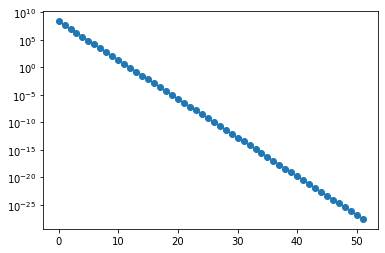

In [61]:
plt.semilogy(hist, 'o-')